# Problema del commesso viaggatore (TSP)

## Definizione
### Dato un grafo $G(V,A)$ a cui è associato un costo $d_{ij}$ ad ogni arco $(i,j) \in A$. Il problema del commesso viaggiatore consiste nel cercare il circuito Hamiltoniano di costo minimo.
### - Un ciclo Hamiltoniano è un ciclo che attraversa tutti i nodi del grafo una ed una sola volta.
### - Il costo di un ciclo Hamiltoniano è dato dalla somma dei costi degli archi che lo compongono.

## Definizione

## Variabili di decisione

### <span style="color:purple">$x_{ij} \quad (i,j) \in A $ </span>  - variabile binaria uguale a $1$ se l'arco $(i,j)$ appartiene al circuito hamiltoniano, 0 altrimenti.


## Funzione obiettivo
### Minimizza il costo totale del circuito hamiltoniano

\begin{equation}
\text{Min} \quad Z = \sum_{(i,j) \in A} d_{ij} \cdot x_{ij}
\end{equation}

## Vincoli di assegnamento
### In una soluzione ammissibile (circuito hamiltoniano) ogni nodo deve avere esattamente un arco entrante ed esattamente un arco uscente.

\begin{equation}
\sum_{i \in V, \ i \neq j} x_{ij} = 1 \quad \quad j \in V 
\end{equation}

\begin{equation}
\sum_{i \in V, \ i \neq j} x_{ji} = 1 \quad \quad j \in V 
\end{equation}

## Vincoli di assenza di sottogiri 

\begin{eqnarray}
& \sum_{i,j \in S} x_{ij} \leq |S| -1 \quad S \subset V
\end{eqnarray}

## Istanza

### Legge il file in input e crea il dizionario *Nodes* con chiave *nome del nodo* e valore *coordinate del nodo*

In [1]:
# Dizionario
Nodes = {}

file = open("lin318.tsp", "r")

line = file.readline()

while not line.startswith("EOF"):
    
    if line.startswith("DIMENSION"):
        NumNodes = int(line.split()[1])
    elif line.startswith("NODE"):
        for i in range(NumNodes) :
            line = file.readline().split()
            # Crea dizionario con chiave il numero del nodo e valori le cordinate
            Nodes[int(line[0])] = (float(line[1]), float(line[2]))
    
    # Va alla riga successiva
    line = file.readline()

### Crea il dizionario Dist con chiave *(i,j)* e valore la distanza euclidea

In [2]:
import math

Dist = {}

for i in Nodes :
    for j in Nodes :
        if i != j :
            difx = Nodes[i][0] - Nodes[j][0]
            dify = Nodes[i][1] - Nodes[j][1]
            Dist[(i,j)] = math.sqrt(difx**2 + dify**2)

## Importa la libreria GRB inizializza il problema e definisce le variabili

In [3]:
import gurobipy as gp
from gurobipy import GRB

mod = gp.Model("TSP")

Xvars = mod.addVars(Dist.keys(), obj = Dist, vtype = GRB.BINARY, name = "x")

Set parameter Username
Set parameter LicenseID to value 2653287
Academic license - for non-commercial use only - expires 2026-04-16


## Vincoli di assegnamento

In [4]:
outstar = mod.addConstrs(gp.quicksum(Xvars[i,j] for j in Nodes if i != j) == 1 for i in Nodes)

instar = mod.addConstrs(Xvars.sum('*',i) == 1 for i in Nodes)


# instar = mod.addConstrs(
#    gp.quicksum(Xvars[j, i] for j in Nodes if j != i) == 1
#    for i in Nodes
#)


## Procedura che individua i sottogiri

### input
- SOL -> lista degli archi nella soluzione corrente

### output
- feasible -> = True se la soluzione è ammissibile
- SubTour -> lista dei nodi del sottogiro individuato

In [5]:
def LookForSubTours(SOL, FirstNode):

    feasible = True

    UnVisited = list(Nodes.keys())
    Visited = []
    NextNode = FirstNode
    
    while NextNode not in Visited :
        
        CurrentNode = NextNode
        UnVisited.remove(CurrentNode)
        Visited.append(CurrentNode)
        
        for (i,j) in SOL :
            if i == CurrentNode :
                NextNode = j
                break
        
    if len(UnVisited) > 0 :
        feasible = False
        
    return feasible, Visited


def LookForMinSubTour(SOL):
    
    UnVisited = list(Nodes.keys())
    MinTour = list(Nodes.keys())
    
    while len(UnVisited) > 0 :
        
        FirstNode = UnVisited[0]
        feasible, SubTour = LookForSubTours(SOL, FirstNode)
        
        if len(SubTour) <= len(MinTour):
            MinTour = SubTour
        
        for i in SubTour :
            UnVisited.remove(i)
        
    return feasible, MinTour

In [6]:
def GeneraLazyConstr(mod, where) :
    
    if where == GRB.Callback.MIPSOL :
        
        SOL = []
        Xvals = mod.cbGetSolution(mod._Xvars)
        for (i,j) in Xvals:
            if Xvals[i,j] > 0.5 :
                SOL.append((i,j))
        
        feasible, Tour = LookForMinSubTour(SOL)
        
        if not feasible :
            mod.cbLazy(gp.quicksum(Xvars[i,j] for i in Tour for j in Tour if i != j) <= len(Tour) -1)

## Risolve il modello

In [7]:
mod.setParam("OutputFlag", 1)
mod._Xvars = Xvars
mod.setParam
mod.Params.LazyConstraints = 1
mod.optimize(GeneraLazyConstr)


Set parameter OutputFlag to value 1
Set parameter LazyConstraints to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
LazyConstraints  1

Optimize a model with 636 rows, 100806 columns and 201612 nonzeros
Model fingerprint: 0x4b021773
Variable types: 0 continuous, 100806 integer (100806 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+01, 5e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.23s
Presolved: 636 rows, 100806 columns, 201612 nonzeros
Variable types: 0 continuous, 100806 integer (100806 binary)

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0          0     infinity      0.0000000e

## Preleva la soluzione e crea una lista *sortedPos* che contiene le posizioni dei nodi nel tour 

In [8]:
print("Valore Soluzione =", mod.ObjVal)

SOL = []
print("Soluzione ottima:")
for (i,j) in Xvars:
    if Xvars[i,j].X > 0.5 :
        SOL.append((i,j))
print(SOL)

import joblib

joblib.dump(SOL,"SOL.joblib")

Valore Soluzione = 42042.5350890505
Soluzione ottima:
[(1, 3), (2, 1), (3, 8), (4, 106), (5, 4), (6, 2), (7, 6), (8, 9), (9, 5), (10, 7), (11, 10), (12, 20), (13, 14), (14, 120), (15, 11), (16, 27), (17, 16), (18, 17), (19, 12), (20, 23), (21, 103), (22, 21), (23, 28), (24, 19), (25, 18), (26, 25), (27, 24), (28, 33), (29, 22), (30, 29), (31, 30), (32, 31), (33, 32), (34, 35), (35, 39), (36, 26), (37, 36), (38, 145), (39, 38), (40, 104), (41, 42), (42, 37), (43, 41), (44, 47), (45, 49), (46, 43), (47, 51), (48, 45), (49, 317), (50, 48), (51, 54), (52, 46), (53, 52), (54, 57), (55, 50), (56, 55), (57, 58), (58, 53), (59, 56), (60, 61), (61, 66), (62, 105), (63, 62), (64, 72), (65, 172), (66, 65), (67, 64), (68, 67), (69, 70), (70, 63), (71, 68), (72, 77), (73, 81), (74, 69), (75, 74), (76, 73), (77, 79), (78, 71), (79, 86), (80, 76), (81, 75), (82, 78), (83, 82), (84, 83), (85, 84), (86, 80), (87, 88), (88, 90), (89, 99), (90, 89), (91, 85), (92, 91), (93, 102), (94, 197), (95, 94), (96

['SOL.joblib']

### Didegna la soluzione

NameError: name 'sortedPos' is not defined

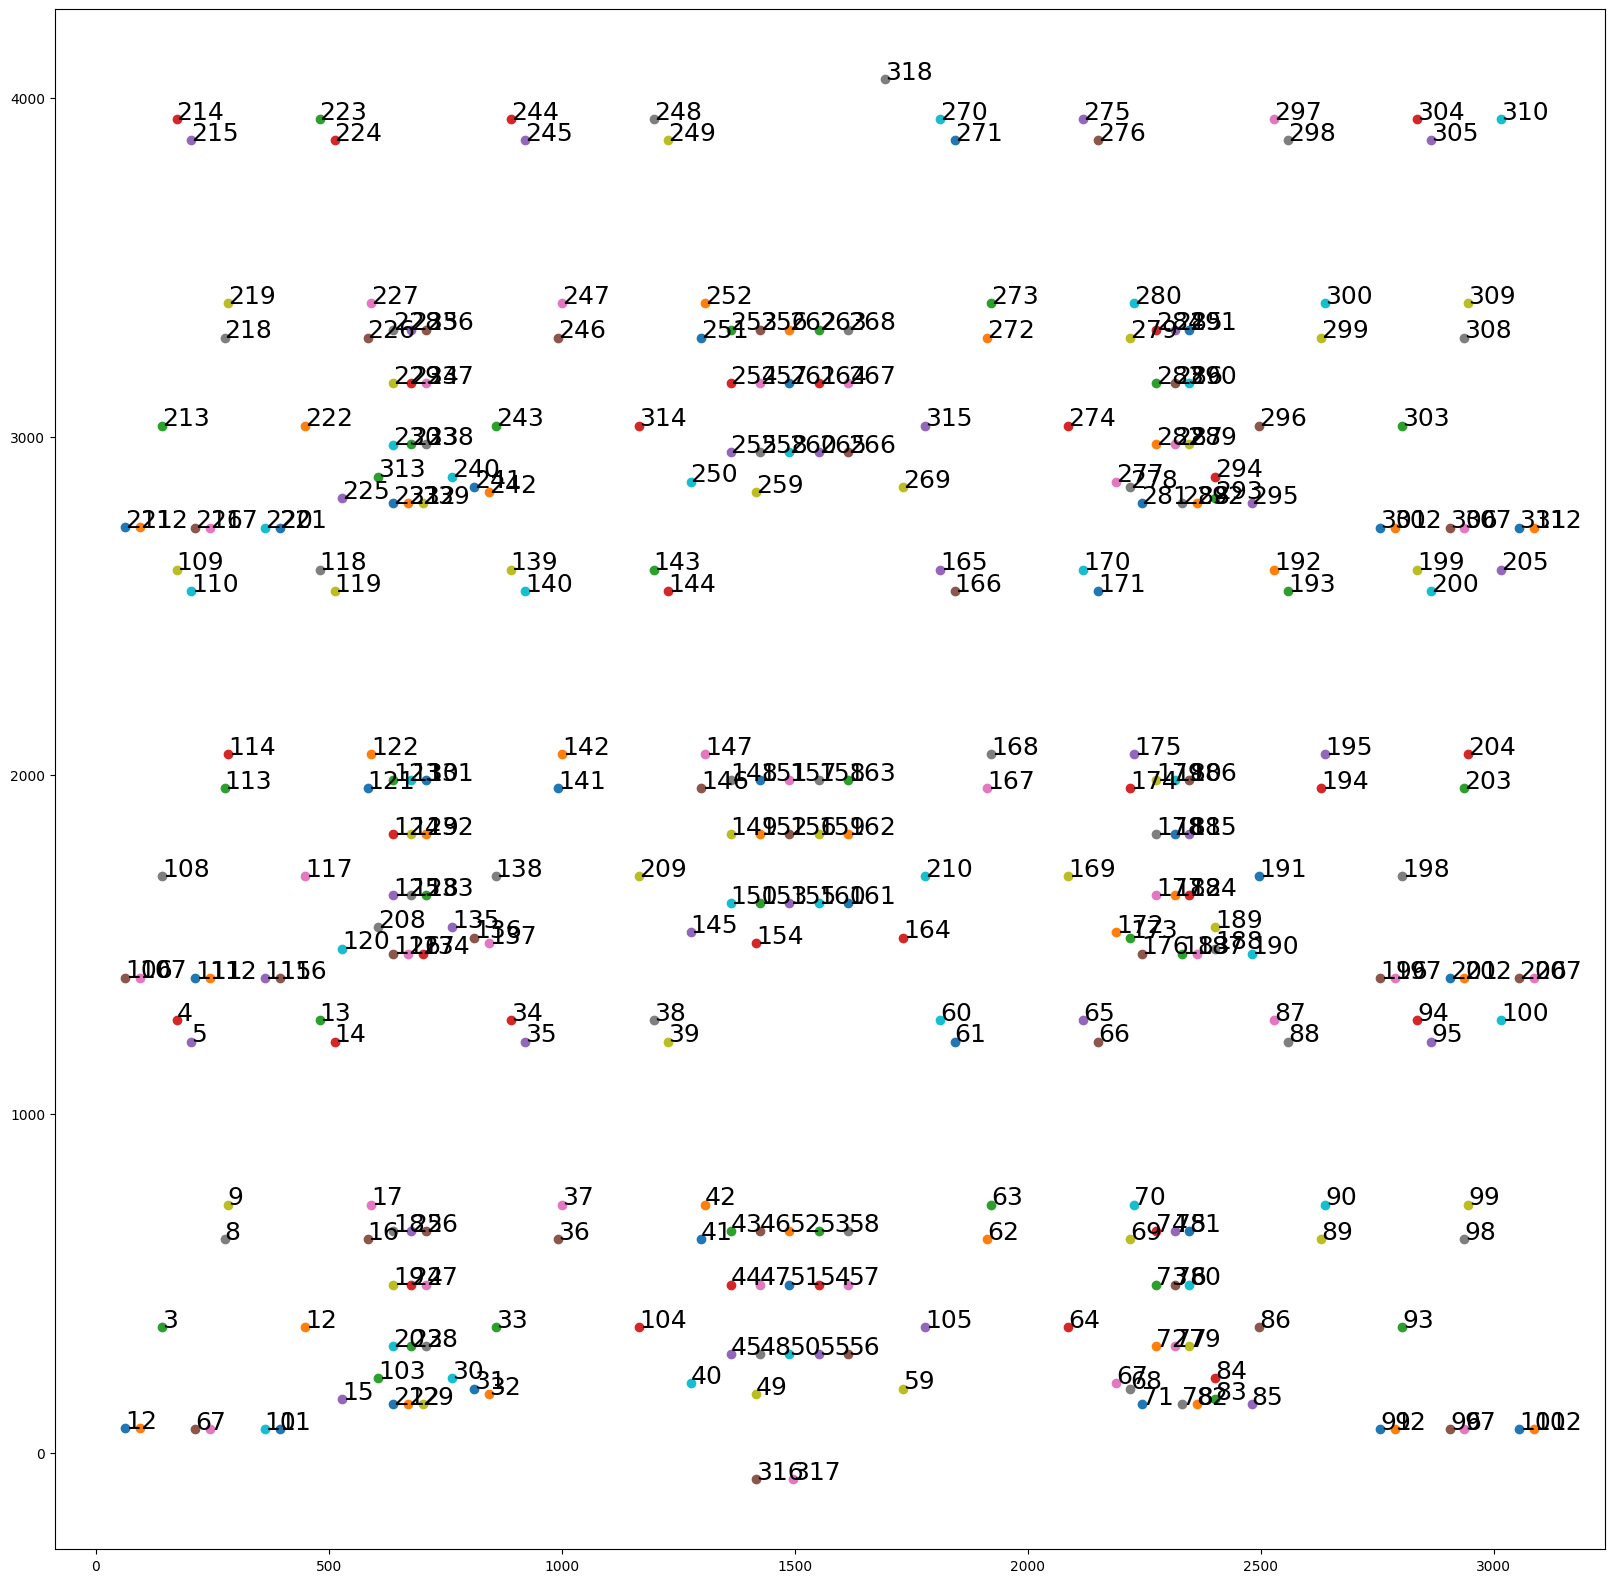

In [9]:
import matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
for i in Nodes:
    plt.scatter(Nodes[i][0],Nodes[i][1])
    plt.text(Nodes[i][0],Nodes[i][1], str(i),fontsize=18)
            

for i in range(NumNodes -1):
      plt.plot([Nodes[sortedPos[i]][0],Nodes[sortedPos[i+1]][0]],
               [Nodes[sortedPos[i]][1],Nodes[sortedPos[i+1]][1]])  
            
plt.plot([Nodes[sortedPos[len(sortedPos)-1]][0],Nodes[sortedPos[0]][0]],
         [Nodes[sortedPos[len(sortedPos)-1]][1],Nodes[sortedPos[0]][1]])
        
plt.xlabel('X');
plt.ylabel('Y');

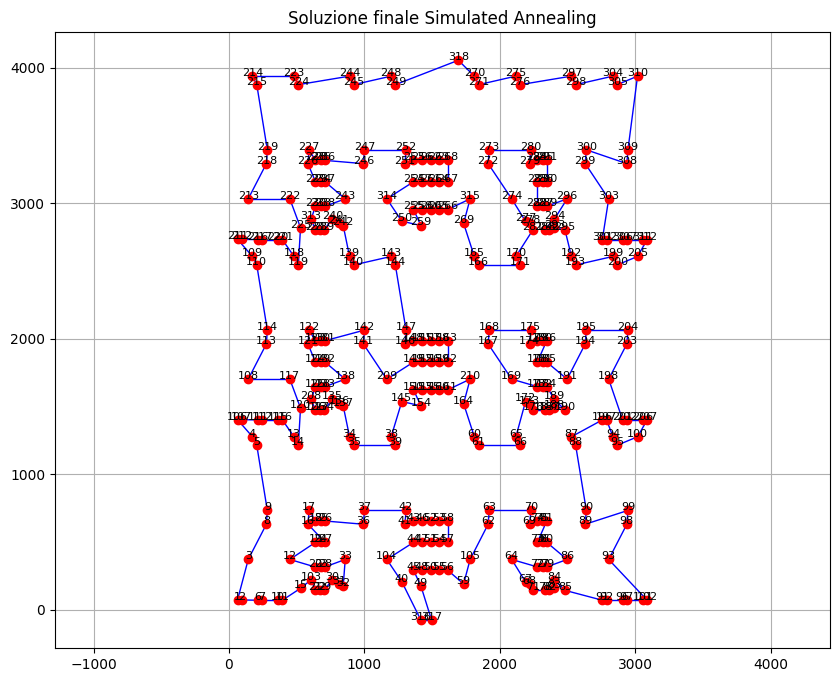

In [10]:
import matplotlib.pyplot as plt

def plot_solution(Nodes, SOL, title="Soluzione TSP"):
    plt.figure(figsize=(10, 8))
    
    # Disegna archi
    for (i, j) in SOL:
        x = [Nodes[i][0], Nodes[j][0]]
        y = [Nodes[i][1], Nodes[j][1]]
        plt.plot(x, y, 'b-', linewidth=1)

    # Disegna nodi
    for k, (x, y) in Nodes.items():
        plt.plot(x, y, 'ro')  # nodi rossi
        plt.text(x, y + 1, str(k), fontsize=8, ha='center')

    plt.title(title)
    plt.axis('equal')
    plt.grid(True)
    plt.show()
    
plot_solution(Nodes, SOL, title="Soluzione finale Simulated Annealing")